In [717]:
import sys
import numpy as np
import math

from tqdm import tqdm

import flory

sys.path.append('../..')
print(np.__version__)


import matplotlib.pyplot as plt
import mpltern
#import matplotlib as mpl
import matplotlib as mpl

from mpltern.datasets import get_shanon_entropies

import importlib

from scipy import cluster, spatial

from scipy.optimize import minimize
from scipy.optimize import basinhopping
from scipy.optimize import differential_evolution

#sys.path.append('/Users/calvinsmith/dufresne_lab/lab_work/llps_classification')
import flory_generate as gen
import flory_plots as plots
importlib.reload(gen)
importlib.reload(plots)

2.0.0


<module 'flory_plots' from '/Users/calvinsmith/dufresne_lab/lab_work/llps_classification/flory_plots.py'>

# FloryClassifier Class



In [718]:
class FloryClassifier:
    
    def __init__(self):
        self.phi_in_thresh = 0.2
        self.phi_H_thresh = 0.1
        self.phi_out = 0.1
        self.phi_in_range = [0.02,0.4]
        self.phi_in_vector = [0.1,0.05]
        self.phi_out_vector = [0.05,0.05]
        self.num_of_points = 6
        self.chi_strength = 5
        self.H_dim = 2
        self.num_comps = self.H_dim + 2
        self.num_comps_sol = self.num_comps + 1
        self.phi_in_min = 0.1
        self.chi_matrix = gen.chi_matrix_w_sol(self.num_comps,self.chi_strength)
        self.chi_matrix_multi = gen.chi_matrix_w_sol(self.num_comps + 1,self.chi_strength)
        self.chi_matrix_custom = [[],[]]
        #print(self.chi_matrix_multi)

    
    def get_info(self):
        ''' Returns information about the FloryClassifier item'''
        print(f"num_comps: {self.num_comps}  num_comps_sol: {self.num_comps_sol}")
        print(f"H_DIM: {self.H_dim}")
        print(f"Phi_out_vector: {self.phi_out_vector}")
        print(f"Phi_in_range: {self.phi_in_range}")
        print(f"num_of_points: {self.num_of_points}")
        print(f"CHI_STRENGTH: {self.chi_strength} \n CHI_MATRIX: {self.chi_matrix}")
        

    
    def step_func(self,x):
        '''Goal Function '''
        if x >= 0.5:
            return 0
        elif 0 <= x < 0.5:
            return 1
        else: 
            raise Exception("Sorry, no numbers below zero")
            
   
    def calc_loss(self,points):
         '''Calculate the Loss'''
        loss = 0
        for point in points:
            loss += (self.step_func(point[0]) - point[1])**2
            
        return loss
    
    ''' Readout Function
    def output_readout_func(self, phi_in, phi_out):
        x = math.exp(-(phi_in/phi_out))
        return x
    ''' 
    def phi_out_readout_func(self,phi_out):
        #x = phi_out[0]/sum(phi_out)
        x = phi_out[0] - phi_out[1]
        x = x/sum(phi_out) 
        x = 1.2*math.tanh(3*x)
        return abs(x)

    
    def evolve_flory_simple(self,point):
        '''Takes a point and evolves it returning the flory object phases '''
        phases = flory.find_coexisting_phases(self.num_comps_sol,self.chi_matrix,point, progress = False)
        return phases

   
    def evolve_components_flory(self, phi_H):
    ''' 
    Main Function
        - Takes a phi_H and phi_in and generates num_points:
                point = [phi_in, phi_H_1 ... , phi_H_n, phi_out, phi_sol]
        - phi_in points = [phi_in_min , ... , phi_in_max] -> [0,1]
        - Evolves each of the points 
        - Returns a numpy array of the most dilute phase for each phi_in point
    '''
        num_comps = len(phi_H) + 2
        #generate comp_points
        
        # picks all the phi_in points given the threshold
        phi_in_points = np.linspace(self.phi_in_min,self.phi_in_thresh, self.num_of_points)
        phi_in_points = phi_in_points.reshape(self.num_of_points,1)
        
        # generates phi_H cords and phi_out cords
        phi_H_points = np.tile(phi_H, [self.num_of_points,1])
        out_array = self.phi_out*np.ones((self.num_of_points,1))
        
        # comp_points is all the points in the phase space that we are going to evolve
        comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
        
        #add solvent component
        phi_sol_points = []
        for phi_in in phi_in_points:
            phi_sol= 1 - (phi_in + self.phi_out + sum(phi_H))
            if phi_sol < 0:
                raise Exception("No Negative Solvent")
            phi_sol_points.append(phi_sol)
            
        #adds the solvent to the point    
        phi_sol_points = np.array(phi_sol_points)
        comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
        #print(comp_points)
        
        #norm_points = np.linspace(0,1, self.num_of_points)

        #Evolves all the points and adds them to evolvedd_comp_points
        evolved_comp_points = []
        for point in tqdm(comp_points):
            phase = flory.find_coexisting_phases(self.num_comps+1,self.chi_matrix,point, progress = False)
            evolved_comp_points.append(phase)

        #Calculates the dilute phases for each point
        dilute_comp_points = []
        for phase in evolved_comp_points:
            x = gen.most_dilute_flory(phase)
            dilute_comp_points.append(x)

        #Plots the most dilute phases for each point 
        dilute_out_comp_arr = np.array(dilute_comp_points)
        test_plot = plots.plot_comp_volume_fraction_v2(dilute_out_comp_arr,self.output_readout_func)
    
        
        return dilute_out_comp_arr
    
    def plot_data_v3(self, data):
        '''
        Plots each of the components of the volume fraction as a scatter plot 
        Data is a numpy array
        '''
        num_comps = data.shape[1]
        num_of_points = data.shape[0]
        norm_points = norm_points = np.linspace(0,1, self.num_of_points)
    
        
        # Label the Plot
        plt.figure
        plt.title('Plot of Component Volume Fractions')
        plt.xlabel('Initial Phi_In')
        plt.ylabel('Volume Fraction')
        plt.ylim(-1, 1)
        
        # Create scatter plot for the different components and labels them
        for i in range(1,(self.num_comps)-2):
            plt.scatter(norm_points, data[:,i], color='green', marker='o', label = f'Phi_H {i}')
        plt.scatter(norm_points,data[:,0], color='blue', marker='o',label = 'Phi_In')

        # Create scatter plot for the phi_out_vector components
        for i in range(len(self.phi_out_vector)):
            plt.scatter(norm_points, data[:,-i-2], color='red', marker='o', label = f'Phi_Out {i+1}')
        plt.scatter(norm_points, data[:,-1], color='yellow', marker='o', label = 'Phi_Sol')

        # Calculates the readout of each point 
        output_comp_points = []
        for point in data:
            out_point = point[-len(self.phi_out_vector)-1:-1]
            #print(out_point)
            x = self.phi_out_readout_func(out_point)
            output_comp_points.append(x)

        #Plots the readout on the plot with purple
        output_comp_points = np.array(output_comp_points)
        plt.scatter(norm_points,output_comp_points, color = 'purple', marker='x')
        plt.plot(norm_points,output_comp_points, color = 'purple', linewidth = 2.0, label = 'Readout Value')
        plt.legend()
        # Show plot
        plt.show()
            
        
    

    def evolve_components_flory_multi(self,phi_H):
        ''' 
        Same as evolve_components_flory but allows for N-dim phi_out
        NOTE: This prints lots of values. Good for debugging
        - Takes a phi_H and phi_in_range and generates num_points:
                point = [phi_in, phi_H_1 ... , phi_H_n, phi_out, phi_sol]
        - phi_in points = [phi_in_min , ... , phi_in_max] -> [0,1]
        - Evolves each of the points 
        - Returns a numpy array of the most dilute phase for each phi_in point
        '''
        
        # Recalculates num_comps ... should fix
        self.num_comps = len(phi_H) + len(self.phi_out_vector) +1
        
        #generate comp_points: ->
        # picks all the phi_in cords given the threshold
        print(self.phi_out_vector)
        phi_in_min = self.phi_in_range[0]
        phi_in_max = self.phi_in_range[1]
        phi_in_points = np.linspace(phi_in_min,phi_in_max, self.num_of_points)
        phi_in_points = phi_in_points.reshape(self.num_of_points,1)
        
        # Generates the phi_H and phi_out_vector cords
        phi_H_points = np.tile(phi_H, [self.num_of_points,1])
        out_array = np.tile(self.phi_out_vector, [self.num_of_points, 1])
    
        # comp_points is all the points in the phase space that we are going to evolve
        comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
        
        #add solvent component
        phi_sol_points = []
        for phi_in in phi_in_points:
            phi_sol= 1 - (phi_in + sum(self.phi_out_vector) + sum(phi_H)) 
            if phi_sol < 0:
                raise Exception("No Negative Solvent")
            phi_sol_points.append(phi_sol)

        # Adds solvent component to points
        phi_sol_points = np.array(phi_sol_points)
        comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
        print(comp_points)
        
        norm_points = np.linspace(0,1, self.num_of_points)

        # Evolves all the points
        evolved_comp_points = []
        for point in tqdm(comp_points):
            phase = flory.find_coexisting_phases(self.num_comps+1,self.chi_matrix_multi,point, progress = False)
            print(f"Number of Phases {len(phase.fractions)}")
            print(f"Phase Fractions + {phase.fractions}")
            print(f"Phase Volumes + {phase.volumes}")
            evolved_comp_points.append(phase)

        # Returns the dilute phases for each point
        dilute_comp_points = []
        for phase in evolved_comp_points:
            x = gen.most_dilute_flory(phase)
            dilute_comp_points.append(x)

        dilute_out_comp_arr = np.array(dilute_comp_points)

        #Peaks the first few data points
        print(f"Data: {dilute_out_comp_arr[0:4]}")
        
        #Plots the data using plot_data_v3
        test_plot = self.plot_data_v3(dilute_out_comp_arr)
    
        
        return dilute_out_comp_arr
           

    def evolve_components_flory_multi_clean(self,phi_H,plotFlag = False):
         ''' 
        Same as evolve_components_flory_multi but removes the print statements and adds the plot flag
        NOTE: plotFlag allows you to for each point plot the volume fractions of the components 
        for all the phasesand the normalized volume fractions.
        - Takes a phi_H and phi_in_range and generates num_points:
                point = [phi_in, phi_H_1 ... , phi_H_n, phi_out, phi_sol]
        - phi_in points = [phi_in_min , ... , phi_in_max] -> [0,1]
        - Evolves each of the points 
        - Returns a numpy array of the most dilute phase for each phi_in point
        '''
        self.num_comps = len(phi_H) + len(self.phi_out_vector) +1

        #generate comp_points: ->
        # picks all the phi_in cords given the threshold
        phi_in_min = self.phi_in_range[0]
        phi_in_max = self.phi_in_range[1]
        phi_in_points = np.linspace(phi_in_min,phi_in_max, self.num_of_points)
        phi_in_points = phi_in_points.reshape(self.num_of_points,1)

        # Creates phi_H and phi_out_vector cords
        phi_H_points = np.tile(phi_H, [self.num_of_points,1])
        out_array = np.tile(self.phi_out_vector, [self.num_of_points, 1])

        # comp_points is all the points in the phase space that we are going to evolve
        comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)

        #Calculate solvent component
        phi_sol_points = []
        for phi_in in phi_in_points:
            phi_sol= 1 - (phi_in + sum(self.phi_out_vector) + sum(phi_H)) 
            if phi_sol < 0:
                raise Exception("No Negative Solvent")
            phi_sol_points.append(phi_sol)

        #Add the solvent component to the points
        phi_sol_points = np.array(phi_sol_points)
        comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)

        #Evolves all the points and plots if plotFlag == True
        evolved_comp_points = []
        for point in tqdm(comp_points):
            phase = flory.find_coexisting_phases(self.num_comps+1,self.chi_matrix_multi,point, progress = False)
            #print(f"Number of Phases {len(phase.fractions)}")
            #print(f"Phase Fractions + {phase.fractions}")
            #print(f"Phase Volumes + {phase.volumes}")
            if plotFlag:
                print(f"POINT: {point}")
                plots.plot_phases(phase)
                plots.plot_phases_vol_norm(phase)
            evolved_comp_points.append(phase)

        #Finds the dilute phases
        dilute_comp_points = []
        for phase in evolved_comp_points:
            x = gen.most_dilute_flory(phase)
            dilute_comp_points.append(x)
            
        #Plots the Data
        dilute_out_comp_arr = np.array(dilute_comp_points)
        test_plot = self.plot_data_v3(dilute_out_comp_arr)
        
        return dilute_out_comp_arr
        

    
        

In [724]:
def optimize_Flory(fc):
    '''
    Optimizes the FloryClassifier Object Using the Differential Evolution Solver from Scipy.optimize
    This needs work... 
    '''
    def evolve_flory_calc_loss(phi_H): 
        ''' 
        Wrapper function for evolve_components_flory_(multi, multi_clean)
        Calculates the loss from each point between the readout_value and ideal function using the loss function.
        Returns the loss
        '''
        # gen.in_bounds checks if a the point is bounds based on seeing if the point is possible
        #Returns OUT OF BOUNDS if the point the optimizer guesses is not valid
        if gen.in_bounds(phi_H,fc.phi_H_thresh):
            print("IN BOUNDS")
            results = fc.evolve_components_flory_multi(phi_H)
            output_comp_points = np.zeros((fc.num_of_points,2))
            count = 0
            phi_init = np.linspace(0,1, fc.num_of_points)

            #Calculates the readout for each point and adds to outpu_comp_points
            for point in results:
                x = fc.phi_out_readout_func(point[-3:-1])
                output_comp_points[count,:] = [phi_init[count],x]
                count+=1
            
            # Calculates the loss
            loss = fc.calc_loss(output_comp_points)
            print(f"LOSS: {loss}")
    
            return loss
        else:
            #This is if it is out of bounds, supposed to disincentivize going out of bounds
            print("OUT OF BOUNDS")
            return 10000

    #This is the scipy optimizer
    bounds_range = [0,fc.phi_H_thresh]
    bounds = np.tile(bounds_range, [fc.H_dim,1] )
    result_DE = differential_evolution(evolve_flory_calc_loss,bounds = bounds, maxiter = 5, popsize = 4)



In [721]:

test = FloryClassifier()

test.get_info()
point = [0.05,0.2,0.2,0.05,0.5]

phases  = test.evolve_flory_simple(point)
print(phases.fractions)




num_comps: 4  num_comps_sol: 5
H_DIM: 2
Phi_out_vector: [0.05, 0.05]
Phi_in_range: [0.02, 0.4]
num_of_points: 6
CHI_STRENGTH: 5 
 CHI_MATRIX: [[0.         4.4372745  2.85603913 5.28937622 0.        ]
 [4.4372745  0.         5.63705166 3.21024829 0.        ]
 [2.85603913 5.63705166 0.         5.76889085 0.        ]
 [5.28937622 3.21024829 5.76889085 0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
[[0.03968424 0.30470091 0.07922641 0.06877139 0.50761704]
 [0.063469   0.06329492 0.35769074 0.02549072 0.49005464]]


Num comps: 5
Num Phase: 2
[0 1]
[[0.02247267 0.02752733]
 [0.17254817 0.02745183]
 [0.04486489 0.15513511]
 [0.03894435 0.01105565]
 [0.28745695 0.21254305]]
5
[0 1]


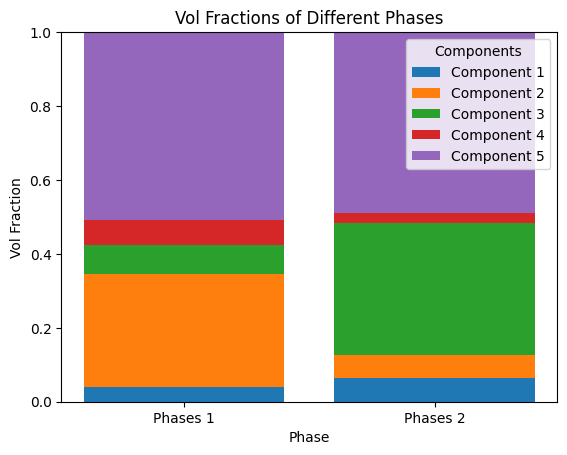

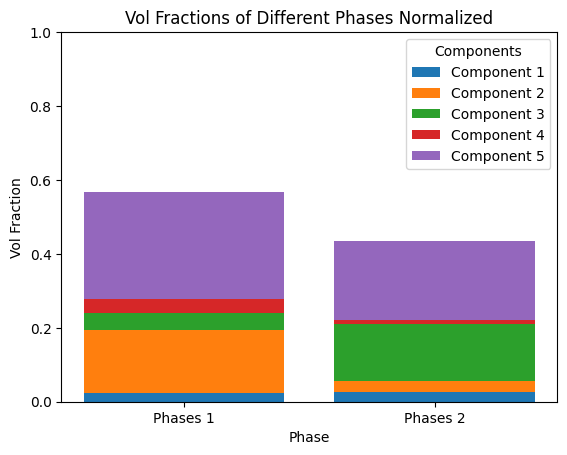

In [722]:
plots.plot_phases(phases)
plots.plot_phases_vol_norm(phases)


In [ ]:

phi_H_test_x = np.linspace(0.02,0.2,3)
phi_H_test_y = np.linspace(0.02,0.2,3)

for x in phi_H_test_x:
    for y in phi_H_test_y:
        phi_H = [x,y]
        test.evolve_components_flory_multi_clean(phi_H)

 17%|███████▌                                     | 1/6 [00:03<00:15,  3.09s/it]

POINT: [0.02 0.2  0.2  0.05 0.05 0.48]
Num comps: 6
Num Phase: 2
[0 1]
[[0.00395835 0.01604165]
 [0.1564779  0.0435221 ]
 [0.00626935 0.19373065]
 [0.00346503 0.04653497]
 [0.00894955 0.04105045]
 [0.12948302 0.35051698]]
6
[0 1]


 33%|███████████████                              | 2/6 [00:07<00:16,  4.00s/it]

POINT: [0.096 0.2   0.2   0.05  0.05  0.404]
Num comps: 6
Num Phase: 3
[0 1 2]
[[0.00543639 0.00483288 0.08573073]
 [0.13669777 0.0030066  0.06029562]
 [0.00241835 0.11935648 0.07822517]
 [0.00138668 0.00692944 0.04168388]
 [0.00426792 0.00441755 0.04131453]
 [0.06827242 0.07001737 0.2657102 ]]
6
[0 1 2]


 50%|██████████████████████▌                      | 3/6 [00:13<00:15,  5.03s/it]

POINT: [0.172 0.2   0.2   0.05  0.05  0.328]
Num comps: 6
Num Phase: 4
[0 1 2 3]
[[0.10573302 0.00466843 0.00413987 0.05745869]
 [0.00433595 0.15988308 0.0023115  0.03346947]
 [0.00318155 0.00182031 0.14687831 0.04811983]
 [0.00444485 0.00127128 0.00770564 0.03657823]
 [0.00281009 0.0046091  0.00485147 0.03772934]
 [0.04773884 0.05948291 0.06376897 0.15700928]]
6
[0 1 2 3]


 67%|██████████████████████████████               | 4/6 [00:20<00:11,  5.59s/it]

POINT: [0.248 0.2   0.2   0.05  0.05  0.252]
Num comps: 6
Num Phase: 5
[0 1 2 3 4]
[[2.16088022e-01 3.73273478e-03 3.28866519e-03 1.65703897e-04
  2.47248737e-02]
 [5.75466580e-03 1.78101496e-01 1.75349093e-03 2.57805094e-04
  1.41325420e-02]
 [4.09754385e-03 1.35997075e-03 1.66904553e-01 2.24418929e-04
  2.74135132e-02]
 [7.81179086e-03 1.17748636e-03 8.45305841e-03 2.43508787e-04
  3.23141556e-02]
 [4.41569246e-03 4.57335278e-03 4.84794500e-03 6.99683685e-03
  2.91661729e-02]
 [6.87824005e-02 4.88865266e-02 5.38530699e-02 2.40983620e-03
  7.80681667e-02]]
6
[0 1 2 3 4]


100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  2.77s/it]

POINT: [0.324 0.2   0.2   0.05  0.05  0.176]
Num comps: 6
Num Phase: 5
[0 1 2 3 4]
[[3.16625782e-01 3.07240160e-03 2.61984697e-03 1.11708579e-03
  5.64883709e-04]
 [5.99396737e-03 1.91475115e-01 1.34367634e-03 2.64776971e-04
  9.22464455e-04]
 [4.14658386e-03 1.05924083e-03 1.92473476e-01 1.53152202e-03
  7.89177360e-04]
 [8.83157286e-03 9.62981772e-04 7.65355122e-03 3.16330444e-02
  9.18849711e-04]
 [4.48230015e-03 3.80904732e-03 3.97515741e-03 9.44553949e-04
  3.67889412e-02]
 [7.34479643e-02 3.97595005e-02 4.53426094e-02 8.50648027e-03
  8.94344562e-03]]
6
[0 1 2 3 4]
POINT: [0.4  0.2  0.2  0.05 0.05 0.1 ]
Num comps: 6
Num Phase: 5
[0 1 2 3 4]
[[3.95443293e-01 2.00656089e-03 1.48615515e-03 7.17493480e-04
  3.46497920e-04]
 [4.44460492e-03 1.94093389e-01 7.16207127e-04 1.40686065e-04
  6.05112590e-04]
 [2.93678528e-03 6.30228405e-04 1.94915072e-01 1.01202928e-03
  5.05885100e-04]
 [6.80587298e-03 5.69386659e-04 4.85169399e-03 3.71715714e-02
  6.01474956e-04]
 [3.19148428e-03 2.534355

100%|█████████████████████████████████████████████| 6/6 [00:22<00:00,  3.67s/it]


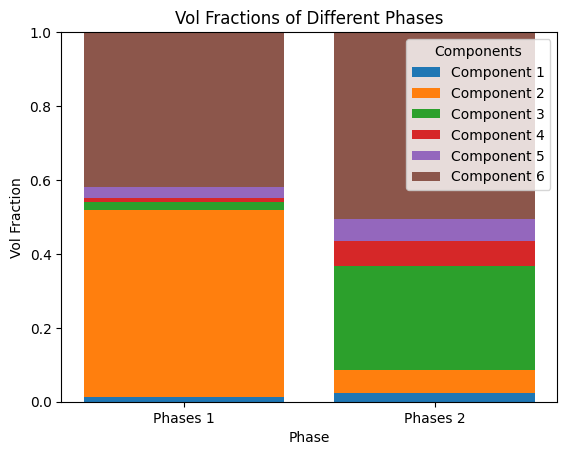

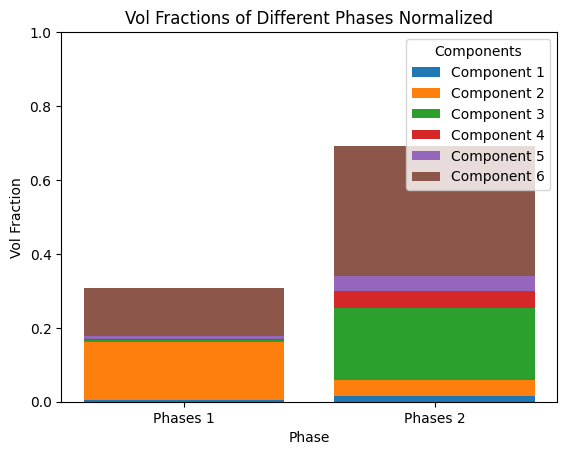

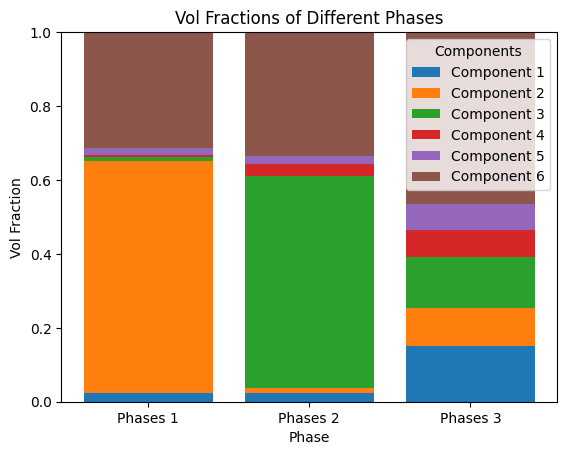

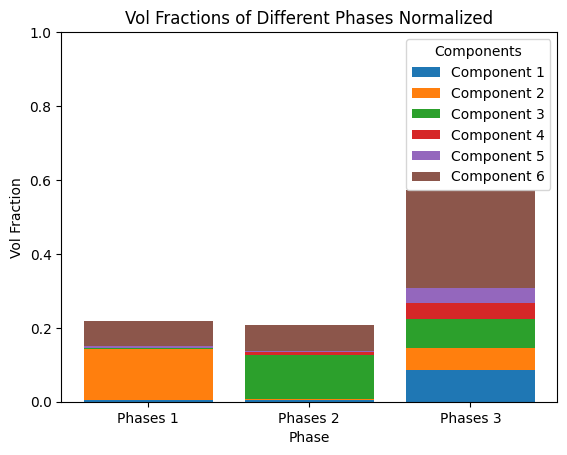

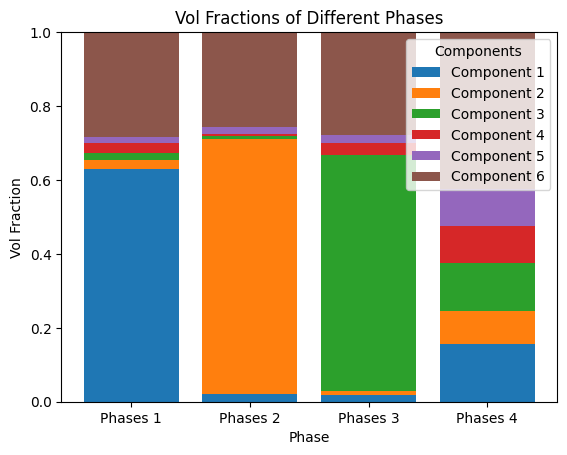

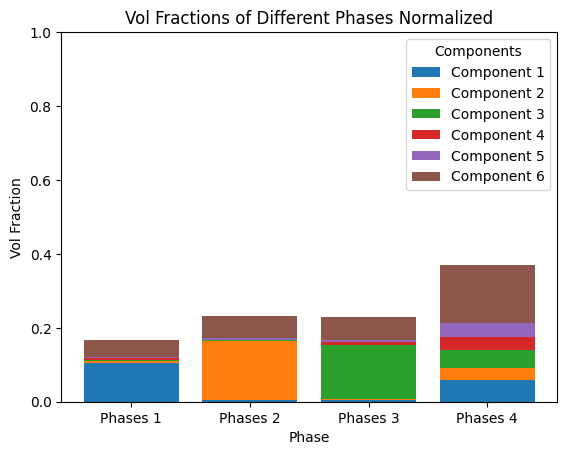

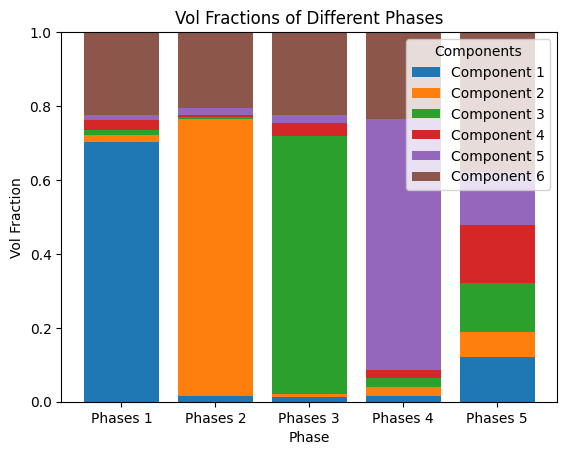

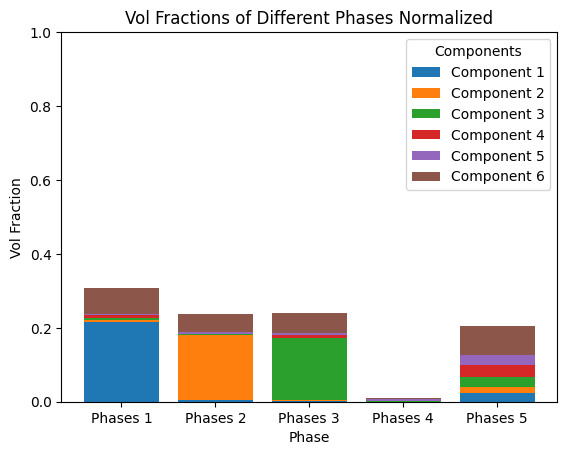

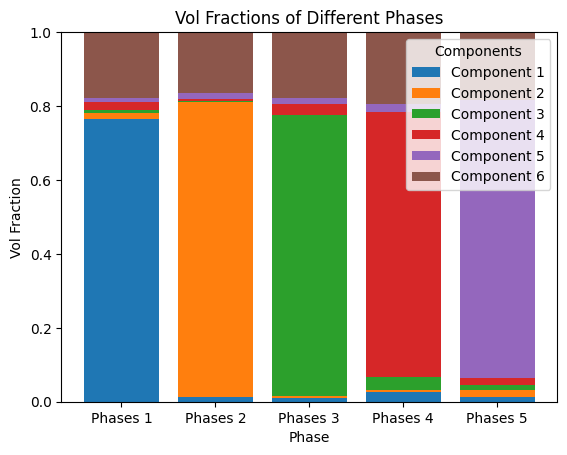

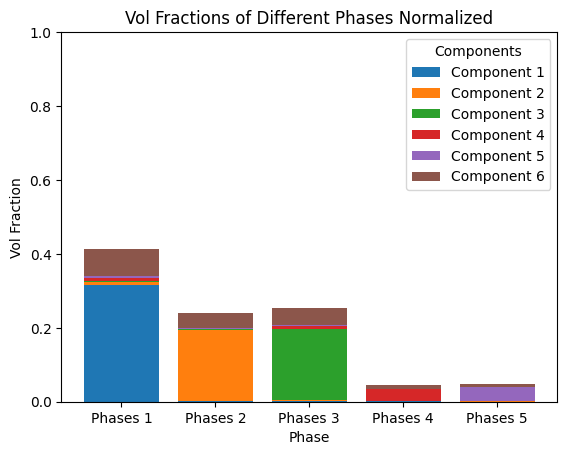

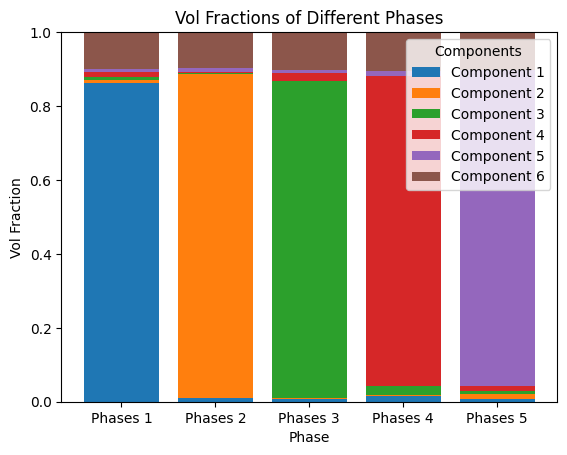

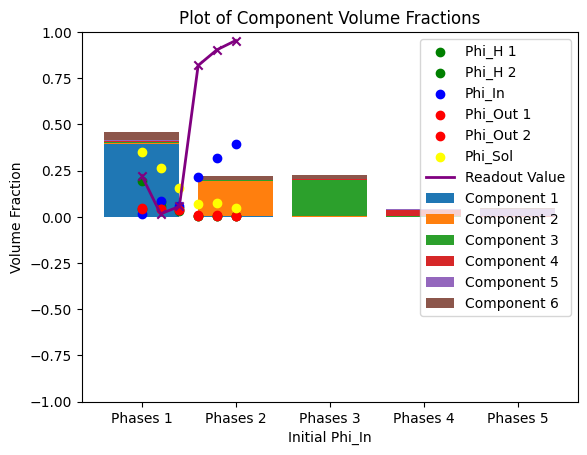

array([[0.01604165, 0.0435221 , 0.19373065, 0.04653497, 0.04105045,
        0.35051698],
       [0.08573073, 0.06029562, 0.07822517, 0.04168388, 0.04131453,
        0.2657102 ],
       [0.05745869, 0.03346947, 0.04811983, 0.03657823, 0.03772934,
        0.15700928],
       [0.21608802, 0.00575467, 0.00409754, 0.00781179, 0.00441569,
        0.0687824 ],
       [0.31662578, 0.00599397, 0.00414658, 0.00883157, 0.0044823 ,
        0.07344796],
       [0.39544329, 0.0044446 , 0.00293679, 0.00680587, 0.00319148,
        0.04614979]])

In [723]:
test.evolve_components_flory_multi_clean([0.2,0.2],plotFlag = True)

OUT OF BOUNDS
OUT OF BOUNDS
IN BOUNDS
[0.05, 0.05]
[[0.02       0.00759645 0.00579633 0.05       0.05       0.86660722]
 [0.096      0.00759645 0.00579633 0.05       0.05       0.79060722]
 [0.172      0.00759645 0.00579633 0.05       0.05       0.71460722]
 [0.248      0.00759645 0.00579633 0.05       0.05       0.63860722]
 [0.324      0.00759645 0.00579633 0.05       0.05       0.56260722]
 [0.4        0.00759645 0.00579633 0.05       0.05       0.48660722]]


 17%|███████▌                                     | 1/6 [00:00<00:00,  6.06it/s]

Number of Phases 1
Phase Fractions + [[0.02       0.00759645 0.00579633 0.05       0.05       0.86660722]]
Phase Volumes + [1.]
Number of Phases 1
Phase Fractions + [[0.096      0.00759645 0.00579633 0.05       0.05       0.79060722]]
Phase Volumes + [1.]


 50%|██████████████████████▌                      | 3/6 [00:08<00:11,  3.69s/it]

Number of Phases 3
Phase Fractions + [[0.14638346 0.00860312 0.00667689 0.05643452 0.05599334 0.72590865]
 [0.25460669 0.00459923 0.00317587 0.03125151 0.02461464 0.68175209]
 [0.01409009 0.00403761 0.00263263 0.0112015  0.32448682 0.64355143]]
Phase Volumes + [0.74945074 0.24431804 0.00623121]


 67%|██████████████████████████████               | 4/6 [00:14<00:09,  4.78s/it]

Number of Phases 3
Phase Fractions + [[0.36536036 0.00320723 0.00190902 0.018874   0.0100891  0.60056027]
 [0.09650996 0.01534694 0.01270089 0.10777133 0.05766626 0.71000463]
 [0.00789511 0.00402028 0.00238605 0.00772261 0.39574695 0.58222901]]
Phase Volumes + [0.58304351 0.35758222 0.05937428]


 83%|█████████████████████████████████████▌       | 5/6 [00:22<00:05,  5.88s/it]

Number of Phases 4
Phase Fractions + [[0.43413784 0.00324156 0.00181108 0.0117731  0.00576121 0.54327523]
 [0.07608003 0.03697917 0.03215092 0.09274283 0.06279594 0.69925112]
 [0.01312752 0.00419003 0.00429197 0.41828498 0.00644048 0.55366498]
 [0.00531567 0.00509872 0.00293136 0.00521545 0.44404276 0.53739605]]
Phase Volumes + [0.72166779 0.12241124 0.07102381 0.08489716]


100%|█████████████████████████████████████████████| 6/6 [00:27<00:00,  4.54s/it]

Number of Phases 4
Phase Fractions + [[0.50858371 0.00240998 0.00117311 0.0070172  0.00311184 0.47770416]
 [0.0075125  0.00303212 0.00302064 0.49873779 0.00330734 0.48438961]
 [0.00306292 0.0043737  0.00223009 0.00299825 0.510544   0.47679102]
 [0.03194237 0.11443109 0.09993892 0.04233156 0.04354061 0.66781547]]
Phase Volumes + [0.7819274  0.08495983 0.08884296 0.04426981]
Data: [[0.02       0.00759645 0.00579633 0.05       0.05       0.86660722]
 [0.096      0.00759645 0.00579633 0.05       0.05       0.79060722]
 [0.14638346 0.00860312 0.00667689 0.05643452 0.05599334 0.72590865]
 [0.36536036 0.00320723 0.00190902 0.018874   0.0100891  0.60056027]]


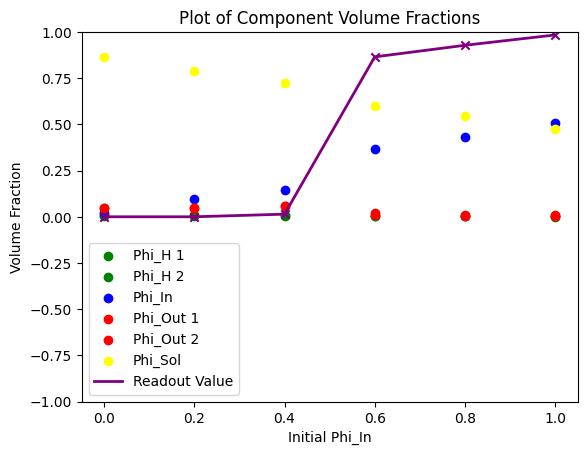

LOSS: 5.5500924128058875
IN BOUNDS
[0.05, 0.05]
[[0.02       0.03729012 0.03030099 0.05       0.05       0.81240889]
 [0.096      0.03729012 0.03030099 0.05       0.05       0.73640889]
 [0.172      0.03729012 0.03030099 0.05       0.05       0.66040889]
 [0.248      0.03729012 0.03030099 0.05       0.05       0.58440889]
 [0.324      0.03729012 0.03030099 0.05       0.05       0.50840889]
 [0.4        0.03729012 0.03030099 0.05       0.05       0.43240889]]


 17%|███████▌                                     | 1/6 [00:00<00:00,  6.10it/s]

Number of Phases 1
Phase Fractions + [[0.02       0.03729012 0.03030099 0.05       0.05       0.81240889]]
Phase Volumes + [1.]
Number of Phases 1
Phase Fractions + [[0.09600002 0.03729012 0.03030099 0.05       0.04999999 0.73640889]]
Phase Volumes + [1.]


 50%|██████████████████████▌                      | 3/6 [00:03<00:05,  1.69s/it]

Number of Phases 2
Phase Fractions + [[0.43053778 0.00369734 0.00200913 0.01074763 0.005791   0.54721714]
 [0.07034222 0.0504989  0.04142543 0.06543414 0.0673831  0.7049162 ]]
Phase Volumes + [0.28222941 0.71777059]


 50%|██████████████████████▌                      | 3/6 [00:06<00:06,  2.27s/it]


KeyboardInterrupt: 

In [484]:
optimize_Flory(test)

# Step Function, Loss Function, Readout Function

In [311]:



    '''Goal Function '''
    def step_func(self,x):
        if x >= 0.5:
            return 0
        elif 0 <= x < 0.5:
            return 1
        else: 
            raise Exception("Sorry, no numbers below zero")
            
    '''Calculate the Loss'''
    def calc_loss(self,points):
        loss = 0
        for point in points:
            loss += (self.step_func(point[0]) - point[1])**2
            
        return loss
    
    ''' Readout Function '''
    def output_readout_func(self, phi_in, phi_out):
        x = math.exp(-(phi_in/phi_out))
        return x




# Main Function 
Takes phi_in_thresh, phi_out, phi_H, num_of_points, chi_strenght as parameters and returns a list of the most dilute phases from each point(dilute_comp_arr)


In [415]:
def evolve_components_flory(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength,chi_matrix):
    num_comps = len(phi_H) + 2
    #generate comp_points
    
    phi_in_min = 0.1
    # picks all the phi_in points given the threshold
    phi_in_points = np.linspace(phi_in_min,phi_in_thresh, num_of_points)
    phi_in_points = phi_in_points.reshape(num_of_points,1)
    # 
    phi_H_points = np.tile(phi_H, [num_of_points,1])
    out_array = phi_out*np.ones((num_of_points,1))
    # comp_points is all the points in the phase space that we are going to evolve
    comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
    #add solvent component
    phi_sol_points = []
    for phi_in in phi_in_points:
        phi_sol= 1 - (phi_in + phi_out + sum(phi_H)) 
        phi_sol_points.append(phi_sol)

    phi_sol_points = np.array(phi_sol_points)

    comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
    print(comp_points)
    norm_points = np.linspace(0,1, num_of_points)

    evolved_comp_points = []
    for point in (comp_points):
        phase = flory.find_coexisting_phases(num_comps+1,chi_matrix,point, progress = False)
        evolved_comp_points.append(phase)

    dilute_comp_points = []
    for phase in evolved_comp_points:
        x = gen.most_dilute_flory(phase)
        dilute_comp_points.append(x)
    
    dilute_out_comp_arr = np.array(dilute_comp_points)

    test_plot = plots.plot_comp_volume_fraction_v2(dilute_out_comp_arr,output_readout_func)

    
    return dilute_out_comp_arr
    

    
            

# Wrapper Function
Wrapper function that only takes phi_H so we can use it in our optimization

In [318]:
num_comps = 4
chi_strength = 10
chi_matrix = gen.chi_matrix_w_sol(num_comps,chi_strength)
print("CHI-MATRIX:")
print(chi_matrix)

def evolve_components_flory_loss(phi_H):
    phi_in_thresh = 0.2
    phi_H_thresh = 0.6
    phi_out = 0.1
    num_of_points = 6
    chi_strength = 10
    H_dim = 2
    readout_func = output_readout_func
    

    if gen.in_bounds(phi_H,phi_H_thresh):
        print("IN BOUNDS")
        results = evolve_components_flory(phi_in_thresh, phi_out, phi_H, num_of_points,chi_strength,chi_matrix)
        output_comp_points = np.zeros((num_of_points,2))
        count = 0
        phi_init = np.linspace(0,1, num_of_points)
        for point in results:
            x = readout_func(point[0],point[-2])
            output_comp_points[count,:] = [phi_init[count],x]
            count+=1
        
        
        loss = calc_loss(output_comp_points)
        print(f"LOSS: {loss}")

        return loss
    else:
        #This is if it is out of bounds, supposed to disincentivize going out of bounds
        print("OUT OF BOUNDS")
        return 10000


CHI-MATRIX:
[[ 0.         10.46776376 10.20477835 10.95154974  0.        ]
 [10.46776376  0.          9.19625071  8.73357737  0.        ]
 [10.20477835  9.19625071  0.          9.81636157  0.        ]
 [10.95154974  8.73357737  9.81636157  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]


# Optimization

IN BOUNDS
[[0.1        0.3698085  0.21098149 0.1        0.21921001]
 [0.12       0.3698085  0.21098149 0.1        0.19921001]
 [0.14       0.3698085  0.21098149 0.1        0.17921001]
 [0.16       0.3698085  0.21098149 0.1        0.15921001]
 [0.18       0.3698085  0.21098149 0.1        0.13921001]
 [0.2        0.3698085  0.21098149 0.1        0.11921001]]


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

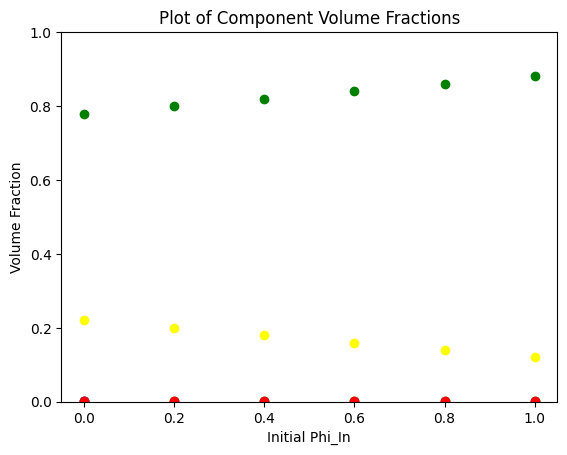

In [320]:



#bounds = [[0,0.4], [0,0.4], [0,0.4],[0,0.4]]
#bounds = [[0,0.4], [0,0.4], [0,0.4]]
bounds = [[0,0.4], [0,0.4]]
result_DE = differential_evolution(evolve_components_flory_loss,bounds = bounds, maxiter = 5, popsize = 2)

In [316]:
def evolve_components_flory_multi_out(phi_in_range, phi_out, phi_H, num_of_points,chi_strength,chi_matrix):
    num_comps = len(phi_H) + len(phi_out) + 1
    #generate comp_points
    
    phi_in_min = phi_in_range[0]
    phi_in_max = phi_in_range[1]
    # picks all the phi_in points given the threshold
    phi_in_points = np.linspace(phi_in_min,phi_in_max, num_of_points)
    phi_in_points = phi_in_points.reshape(num_of_points,1)
    # 
    phi_H_points = np.tile(phi_H, [num_of_points,1])
    out_array = np.tile(phi_out, [num_of_points, 1])

    
    # comp_points is all the points in the phase space that we are going to evolve
    comp_points = np.concatenate((phi_in_points, phi_H_points, out_array), axis = 1)
    #add solvent component
    phi_sol_points = []
    for phi_in in phi_in_points:
        phi_sol= 1 - (phi_in + sum(phi_out) + sum(phi_H)) 
        phi_sol_points.append(phi_sol)

    phi_sol_points = np.array(phi_sol_points)

    comp_points = np.concatenate((comp_points,phi_sol_points), axis = 1)
    print(comp_points)
    norm_points = np.linspace(0,1, num_of_points)

    evolved_comp_points = []
    for point in (comp_points):
        phase = flory.find_coexisting_phases(num_comps+1,chi_matrix,point, progress = False)
        evolved_comp_points.append(phase)

    dilute_comp_points = []
    for phase in evolved_comp_points:
        x = gen.most_dilute_flory(phase)
        dilute_comp_points.append(x)
    
    dilute_out_comp_arr = np.array(dilute_comp_points)

    test_plot = plots.plot_comp_volume_fraction_v3(dilute_out_comp_arr,output_readout_func)

    
    return dilute_out_comp_arr
    

    
            